# Análise de Depressão Estudantil com SVM 

Este notebook implementa um modelo de Support Vector Machine para classificação binária de depressão em estudantes. O SVM é uma técnica de aprendizado de máquina que encontra o hiperplano ótimo para separar classes diferentes, sendo especialmente eficaz para problemas de classificação com datasets de média dimensionalidade.

## Objetivos
- Construir um modelo de SVM
- Regularizar dos parâmetros 𝐶 e 𝛾 (gama) através
de cross validation
- Analisar a existência de overfitting;
- Avaliar o desempenho do modelo

Carregamos as bibliotecas necessárias para preprocessamento de dados, modelagem SVM, validação cruzada e visualização de resultados.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

### 1. Carregar o conjunto de dados

Carregamos o dataset limpo de depressão em estudantes que foi preprocessado na etapa de EDA. Este dataset contém features engineered específicas para melhorar a capacidade preditiva do modelo.

In [2]:
df = pd.read_csv("../data/Student_Depression_Cleaned.csv", sep=',')

### 2. Definição das features e o target

In [3]:
features = [
    'Academic Pressure', 'Have you ever had suicidal thoughts ?','Weighted Stress',
    'Financial Stress','Extreme_Mental_Crisis','Mental_Vulnerability_Score','Mental_Health_Crisis_Index','Stress_Vulnerability_Multiplier',
    'Ultimate_Depression_Predictor','Family History of Mental Illness','Work/Study Hours',
]

X = df[features]
y = df['Depression']

In [21]:
print("Distribuição das classes:")
print(y.value_counts())

Distribuição das classes:
Depression
0    7935
1    7935
Name: count, dtype: int64


### 3. Divisão dos dados em conjuntos de treino e teste

- **80% para treino**: Dados suficientes para o modelo aprender os padrões
- **30% para teste**: Amostra representativa para avaliação final

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1) 

#### 3.1. Padronização dos dados

A padronização é crucial para SVM pois o algoritmo é sensível à escala das features. O StandardScaler normaliza as features para média 0 e desvio padrão 1, garantindo que todas tenham igual importância no cálculo das distâncias.

In [5]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### 4. Definição da grade de parâmetros para o GridSearchCV e Treinamento do Modelo

Utilizamos Grid Search com validação cruzada (CV=10) para encontrar os melhores hiperparâmetros:
- **C**: Parâmetro de regularização (controla trade-off entre margem e classificação correta)
- **gamma**: Parâmetro do kernel RBF (controla a influência de cada exemplo de treino)
- **kernel**: Usamos RBF (Radial Basis Function) por sua eficácia em problemas não-lineares

O modelo é salvo junto com o scaler para uso posterior, garantindo consistência no preprocessamento.

In [ ]:
#param_grid = {
#   'C': [0.1, 1, 10, 50, 100],
#    'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
#    'kernel': ['rbf']
#}

In [ ]:
#grid = GridSearchCV(estimator=SVC(kernel='rbf'), param_grid=param_grid, cv=5)
#grid.fit(X_train_scaled, y_train)

,estimator,SVC()
,param_grid,"{'C': [0.1, 1, ...], 'gamma': [1, 0.1, ...], 'kernel': ['rbf']}"
,scoring,None
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,C,0.1


In [ ]:
#best_model = grid.best_estimator_
#print(f"Melhores parâmetros encontrados: {grid.best_params_}")

Melhores parâmetros encontrados: {'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}


In [ ]:
#joblib.dump(best_model, '../modelos/models/svm_best_model3.pkl')
#joblib.dump(scaler, '../modelos/models/svm_scaler3.pkl')

['../modelos/models/svm_scaler3.pkl']

#### 4.1 Aplicando SVM com o modelo salvo

Carregamos o modelo SVM otimizado e o scaler salvos anteriormente. Isso permite reutilização do modelo sem necessidade de retreinar, mantendo a consistência do preprocessamento.

In [11]:
best_model = joblib.load('../modelos/models/svm_best_model3.pkl')
scaler = joblib.load('../modelos/models/svm_scaler3.pkl')

In [12]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [13]:
y_train_pred = best_model.predict(X_train_scaled)
y_test_pred = best_model.predict(X_test_scaled)

### 5. Cálculo Ein e Eout

Utilizamos uma divisão 80-20 com `random_state=1` para garantir reprodutibilidade. Esta proporção é adequada para o tamanho do dataset, permitindo:
- **80% para treino**: Dados suficientes para o modelo aprender os padrões
- **20% para teste**: Amostra representativa para avaliação final

In [14]:
ein = 1 - accuracy_score(y_train, y_train_pred)
eout = 1 - accuracy_score(y_test, y_test_pred)
print(f"Erro dentro da amostra (Ein): {ein:.4f}")
print(f"Erro fora da amostra (Eout): {eout:.4f}")

Erro dentro da amostra (Ein): 0.1689
Erro fora da amostra (Eout): 0.1749


### 6. Cálculo do valor esperado de Eout (limite superior)

O **limite superior teórico de Eout** é baseado na teoria estatística do SVM, onde o número de vetores de suporte dividido pelo tamanho da amostra fornece uma estimativa conservadora do erro de generalização.

Menos vetores de suporte geralmente indicam melhor generalização e menor complexidade do modelo.

In [15]:
n_support_vectors = best_model.support_vectors_.shape[0]
n_training_samples = X_train.shape[0]
expected_eout_bound = n_support_vectors / n_training_samples

print(f"Número de vetores de suporte: {n_support_vectors}")
print(f"Tamanho do conjunto de treino: {n_training_samples}")
print(f"Valor esperado de Eout (limite superior): {expected_eout_bound:.4f}")

Número de vetores de suporte: 6625
Tamanho do conjunto de treino: 12696
Valor esperado de Eout (limite superior): 0.5218


### 7. Gráfico de Erros

A visualização comparativa entre Ein e Eout permite avaliar rapidamente:
- **Overfitting**: Se Eout > Ein
- **Boa generalização**: Se Ein ≈ Eout e ambos são baixos
- **Underfitting**: Se ambos são altos

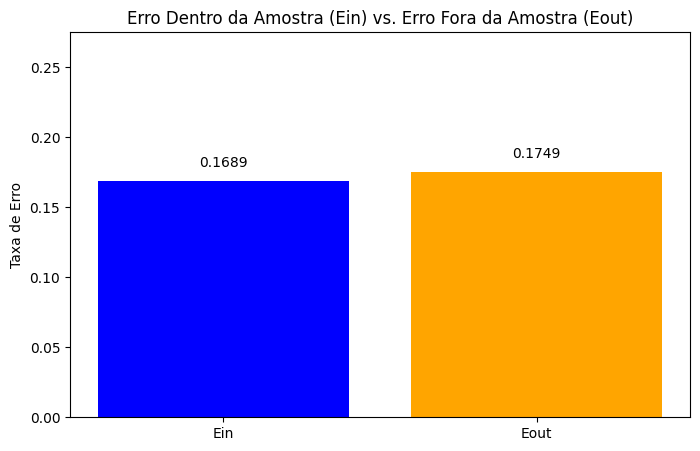

In [16]:
plt.figure(figsize=(8, 5))
plt.bar(['Ein', 'Eout'], [ein, eout], color=['blue', 'orange'])
plt.title('Erro Dentro da Amostra (Ein) vs. Erro Fora da Amostra (Eout)')
plt.ylabel('Taxa de Erro')
plt.ylim(0, max(ein, eout) + 0.1)
for i, v in enumerate([ein, eout]):
    plt.text(i, v + 0.01, f"{v:.4f}", ha='center')
plt.show()

### 8. Métricas de classificação

O **Classification Report** fornece métricas detalhadas por classe:
- **Precision**: Proporção de predições positivas corretas
- **Recall (Sensitivity)**: Proporção de casos positivos reais identificados
- **F1-Score**: Média harmônica entre precision e recall
- **Support**: Número de amostras em cada classe

Em problemas de saúde mental, o recall para a classe "Depressivo" é particularmente importante para minimizar falsos negativos.

In [17]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.84      0.81      0.82      1596
           1       0.81      0.84      0.83      1578

    accuracy                           0.83      3174
   macro avg       0.83      0.83      0.83      3174
weighted avg       0.83      0.83      0.83      3174



O modelo SVM apresentou um desempenho geral sólido, com uma acurácia de 83%. As métricas para as classes "Não Depressivo" (classe 0) e "Depressivo" (classe 1) estão bem equilibradas, com precision, recall e F1-score em torno de 0.82 a 0.83 para ambas as classes. Isso indica que o modelo é capaz de identificar ambas as classes de forma consistente, sem favorecer uma classe em detrimento da outra.

### 9. Matriz de Confusão

A **Matriz de Confusão** visualiza o desempenho detalhado da classificação:
- **Verdadeiros Positivos (TP)**: Casos depressivos corretamente identificados
- **Falsos Positivos (FP)**: Não depressivos classificados como depressivos  
- **Falsos Negativos (FN)**: Casos depressivos não identificados (crítico em saúde mental)
- **Verdadeiros Negativos (TN)**: Não depressivos corretamente classificados

A matriz permite calcular métricas específicas e identificar padrões de erro do modelo.

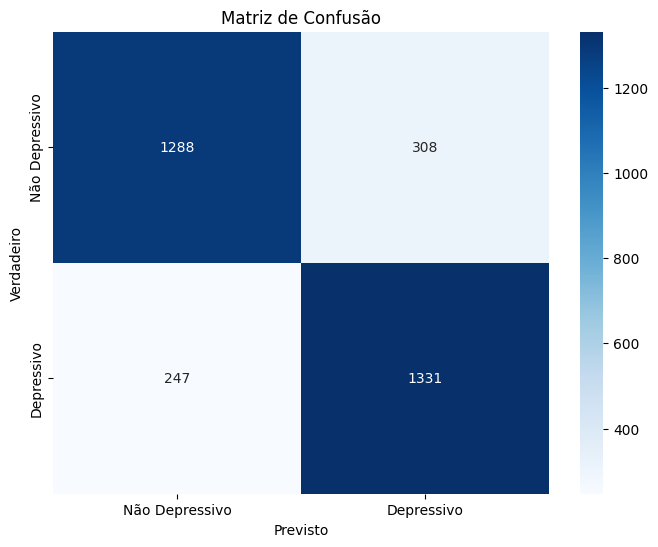

In [18]:
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Não Depressivo', 'Depressivo'], yticklabels=['Não Depressivo', 'Depressivo'])
plt.title('Matriz de Confusão')
plt.ylabel('Verdadeiro')
plt.xlabel('Previsto')
plt.show()